# **Facies classification using Machine Learning**

The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/). This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011).

First, let's install the required packages to train this model and download the dataset. We will present two versions using K-Means and Kohonen's self-organizing maps (aka SOM).

In [84]:
!pip install sklearn somoclu > /dev/null 2>&1
!rm -rf data/
!mkdir -p data/
!wget https://raw.githubusercontent.com/jcfaracco/seismic_framework/main/data/facies_data.csv -O data/facies_data.csv
!wget https://raw.githubusercontent.com/jcfaracco/seismic_framework/main/data/nofacies_data.csv -O data/nofacies_data.csv

--2021-05-10 03:52:26--  https://raw.githubusercontent.com/jcfaracco/seismic_framework/main/data/facies_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245903 (240K) [text/plain]
Saving to: ‘data/facies_data.csv’

data/facies_data.cs 100%[===================>] 240.14K  --.-KB/s    in 0.03s   

2021-05-10 03:52:26 (8.53 MB/s) - ‘data/facies_data.csv’ saved [245903/245903]

--2021-05-10 03:52:26--  https://raw.githubusercontent.com/jcfaracco/seismic_framework/main/data/nofacies_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

## **Exploring the dataset**

First, we will examine the data set we will use to train the classifier. The training data is contained in the file `facies_data.csv`. The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type). We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.


In [85]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

filename = 'data/facies_data.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


Remove a single well to use as a blind test later.

In [86]:
blind = training_data[training_data['Well Name'] == 'SHANKLE']
training_data = training_data[training_data['Well Name'] != 'SHANKLE']

This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

The seven predictor variables are:

* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10), [photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are:

1. Nonmarine sandstone
2. Nonmarine coarse siltstone
3. Nonmarine fine siltstone
4. Marine siltstone and shale
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close. Mislabeling within these neighboring facies can be expected to occur. The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies | Label | Adjacent Facies
-------|-------|----------------
   1   |   SS  |               2
   2   |  CSiS |             1,3
   3   |  FSiS |               2
   4   |  SiSh |               5
   5   |   MS  |             4,6
   6   |   WS  |             5,7
   7   |   D   |             6,8
   8   |   PS  |           6,7,9
   9   |   BS  |             7,8

Let's clean up this dataset. The 'Well Name' and 'Formation' columns can be turned into a categorical data type.

In [87]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['SHRIMPLIN', 'ALEXANDER D', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (9, object): ['SHRIMPLIN', 'ALEXANDER D', 'LUKE G U', 'KIMZEY A', ..., 'NOLAN',
                         'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

These are the names of the 10 training wells in the Council Grove reservoir. Data has been recruited into pseudo-well 'Recruit F9' to better represent facies 9, the Phylloid-algal bafflestone.

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial. We also create the abbreviated facies labels, and add those to the facies_vectors dataframe.


In [88]:
# 1=sandstone
# 2=c_siltstone
# 3=f_siltstone 
# 4=marine_silt_shale
# 5=mudstone
# 6=wackestone
# 7=dolomite
# 8=packstone
# 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,4.615676,2908.853378,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,2.475808,139.010855,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2818.500000,43.778250,0.502000,1.800000,8.350000,3.200000,1.000000,0.278000
50%,4.000000,2939.000000,64.817000,0.645613,4.400000,11.857500,3.600000,2.000000,0.531000
75%,7.000000,3015.125000,80.322500,0.823000,7.600000,15.750000,4.400000,2.000000,0.772000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Let's take a look at the data from individual wells in a more familiar log plot form. We will create plots for the five well log variables, as well as a log for facies labels.

In [89]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells. The function was written to take a list of colors and facies labels as parameters.

We then show log plots for wells `SHRIMPLIN`.

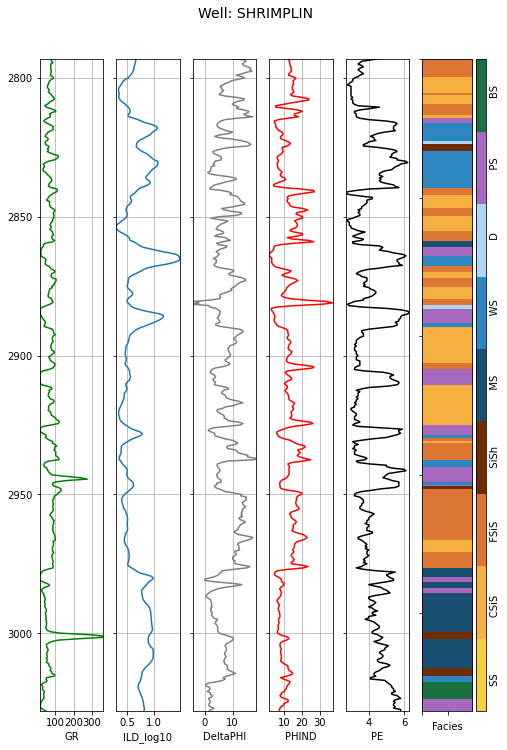

In [90]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

In addition to individual wells, we can look at how the various facies are represented by the entire training set. Let's plot a histgram of the number of training examples for each facies class.

SS      179
CSiS    851
FSiS    663
SiSh    264
MS      277
WS      511
D       124
PS      646
BS      185
Name: Facies, dtype: int64

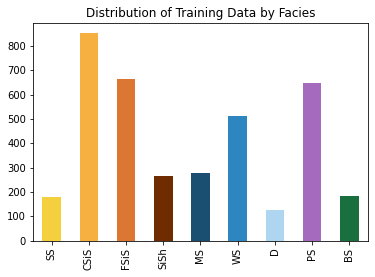

In [91]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

## **Conditioning the data set**

Now we extract just the feature variables we need to perform the classification. The predictor variables are the five wireline values and two geologic constraining variables. We also get a vector of the facies labels that correspond to each feature vector.

In [92]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3700.000000,3700.000000,3700.000000,3700.000000,2783.000000,3700.000000,3700.000000
mean,64.873649,0.663053,4.651677,12.892826,3.805693,1.540000,0.524125
std,30.817166,0.253863,5.109006,6.796219,0.894118,0.498465,0.287147
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,43.778250,0.502000,1.800000,8.350000,3.200000,1.000000,0.278000
50%,64.817000,0.645613,4.400000,11.857500,3.600000,2.000000,0.531000
75%,80.322500,0.823000,7.600000,15.750000,4.400000,2.000000,0.772000
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called whitening). Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance). The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier. The StandardScalar class can be fit to the training set, and later used to standardize any training data.


In [93]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


## **Applying the classification models to the blind data**

We held a well back from the training, and stored it in a dataframe called blind:


In [94]:
blind

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
937,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
938,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
939,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
940,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
941,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935
...,...,...,...,...,...,...,...,...,...,...,...
1381,8,C LM,SHANKLE,3006.0,32.84,1.120,-2.2,3.455,5.1,2,0.060
1382,8,C LM,SHANKLE,3006.5,25.16,1.112,-1.6,2.890,4.8,2,0.045
1383,8,C LM,SHANKLE,3007.0,25.16,1.112,-1.6,2.890,4.8,2,0.030
1384,4,C LM,SHANKLE,3007.5,26.22,1.092,-0.4,3.400,4.5,2,0.030


Now, the first machine learn algorithm tested is [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit. This code splits the test case but as K-Means uses only the train dataset, the other ones can be discarded. For this specific method, only `X_train` is used to train and `X_blind` to predict the assumptions of the well logs.

In [95]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

n_clusters = len(facies_labels)

kmeans = KMeans(n_clusters)

kmeans = kmeans.fit(np.nan_to_num(X_train))

y_blind = blind['Facies'].values
well_features = blind.drop(['Facies', 'Formation', 'Well Name', 'Depth'], axis=1)
X_blind = scaler.transform(well_features)

y_pred_kmeans = kmeans.predict(X_blind)

In [96]:
feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,51.469,0.965,3.083,7.708,3.152,2,0.661


The second machine learn algorithm is SOM. For this specific case, the best solution is [Somoclu](https://somoclu.readthedocs.io/en/stable/) because there are some interesting features to clusterize the BMUs if necessary. It is possible to plot the U-matrix to see the groups.

In [97]:
import somoclu
from sklearn.cluster import KMeans

algorithm = KMeans(n_clusters)

def predict(som_model, data):
    W = som_model.codebook.reshape((som_model.codebook.shape[0] * som_model.codebook.shape[1], som_model.codebook.shape[2]))
    X = data

    D = -2*np.dot(W, X.T) + (W**2).sum(1)[:, None] + (X**2).sum(1)[:, None].T
    BMU = (D==D.min(0)[None,:]).astype("float32").T
    NBMU =  BMU.reshape((X.shape[0], som_model.codebook.shape[0], som_model.codebook.shape[1]))
    return np.vstack(NBMU.nonzero()[1:][::-1]).T

def convert_coords(data, n_rows):
    new_data = []
    i = 0
    for item in data:
        x, y = item
        new_data.append(som.clusters[y, x])
    return np.array(new_data)

n_rows, n_columns = 13, 15
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, initialization="pca")

som.train(np.nan_to_num(X_train))

som.cluster(algorithm=algorithm)

y_pred_som = predict(som, X_blind)
y_pred_som = convert_coords(y_pred_som, n_rows)

This is a useless postprocessing phase. It is required to map each group to the proper facie (label).

In [98]:
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import confusion_matrix

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

def silly_map(y_data):
    shuffled = np.arange(n_clusters)
    acc = 0.0
    y_new = None
    for p in multiset_permutations(shuffled):
        y_data_new = np.ones(y_data.size) * -1
        for j in range(n_clusters):
            y_data_new[y_data == j] = p[j]
        cv_conf_data = confusion_matrix(y_blind, y_data_new)
        if accuracy(cv_conf_data) >= acc:
            acc = accuracy(cv_conf_data)
            y_new = y_data_new
    return y_new

y_pred_kmeans_new = silly_map(y_pred_kmeans)
y_pred_som_new = silly_map(y_pred_som)

blind['PredictionKMeans'] = y_pred_kmeans_new
blind['PredictionSOM'] = y_pred_som_new

cv_conf_kmeans = confusion_matrix(y_blind, y_pred_kmeans_new)
cv_conf_som = confusion_matrix(y_blind, y_pred_som_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Time to see the accuracy of each algorithm...

In [99]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

print('Optimized facies classification accuracy = %.3f' % accuracy(cv_conf_kmeans))
print('Optimized facies classification accuracy = %.3f' % accuracy(cv_conf_som))
print('Optimized adjacent facies classification accuracy = %.3f' % accuracy_adjacent(cv_conf_kmeans, adjacent_facies))
print('Optimized adjacent facies classification accuracy = %.3f' % accuracy_adjacent(cv_conf_som, adjacent_facies))

Optimized facies classification accuracy = 0.488
Optimized facies classification accuracy = 0.579
Optimized adjacent facies classification accuracy = 0.713
Optimized adjacent facies classification accuracy = 0.775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


Finally, let's see a visual comparison of each prediction of the facies.

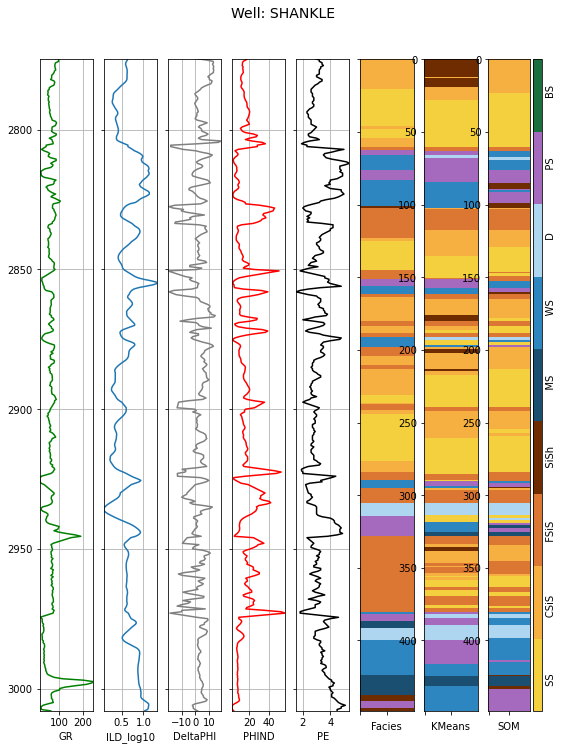

In [100]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre + 'KMeans'].values,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs[compadre + 'SOM'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[7])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im3, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('KMeans')
    ax[7].set_xlabel('SOM')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

compare_facies_plot(blind, 'Prediction', facies_colors)